### Import Dependencies

In [1]:
from pathlib import Path
from pynwb import NWBHDF5IO
import numpy as np
import matplotlib.pyplot as plt
from dandi import dandiapi, download
import os

In [2]:
output_dir = "./plots"
output_dir = Path(output_dir)
output_dir.mkdir(exist_ok=True)

### Download and Open NWB file
The NWB files can be found in Dandiset 001424 on DANDI. The NWB can be downloaded with the DANDI client and then opened with pynwb

In [3]:
dandiset_id = "001424"
# dandi_filepath = "sub-794237/sub-794237_ses-20250403T103830_image+ophys.nwb"
# dandi_filepath = "sub-794237/sub-794237_ses-20250424T142019_image+ophys.nwb"
dandi_filepath = "sub-794237/sub-794237_ses-20250508T145040_image+ophys.nwb"
download_loc = "."

In [4]:
client = dandiapi.DandiAPIClient()
dandiset = client.get_dandiset(dandiset_id)
file = dandiset.get_asset_by_path(dandi_filepath)
file_url = file.download_url
filename = dandi_filepath.split("/")[-1]
filepath = f"{download_loc}/{filename}"
if os.path.exists(filepath):
    print("File already exists")
else:
    # This can sometimes take a while depending on the size of the file
    download.download(file_url, output_dir=download_loc)
    print(f"Downloaded file to {filepath}")

File already exists


In [5]:
io = NWBHDF5IO(filepath, mode="r", load_namespaces=True)
nwb = io.read()

c:\Users\carter.peene\AppData\Local\Programs\Python\Python313\Lib\site-packages\pynwb\file.py:158: UserWarning: Date is missing timezone information. Updating to local timezone.
  args_to_set['date_of_birth'] = _add_missing_timezone(date_of_birth)


The NWB and its sections are rendered in the notebook here for easy exploration. The most important sections are `intervals` which contains the stimulus information, and `processing` which contains the processed ophys recording.

In [6]:
nwb

Data type,float64
Shape,"(1, 323, 832)"
Array size,2.05 MiB
Chunk shape,None
Compression,None
Compression opts,None
Compression ratio,1.0
Data type,float64
Shape,"(1,)"
Array size,8.00 bytes
Chunk shape,None


### Examining the Stimulus
Shown here is the stimulus table, which includes the parameterized stimulus information over time. In these experiments, the type of stimulus 'epoch' is not recorded. The receptive field mapping epoch of the session must be found by looking at the position columns. Once there is variation in the x-position and y-position, this is the portion of the table that will be analyzed for Receptive Fields in this notebook.

In [7]:
nwb.intervals.keys()

dict_keys(['stimulus_presentations'])

In [8]:
stim_table_name = "stimulus_presentations"
stim_table = nwb.intervals[stim_table_name].to_dataframe()
stim_table[:10]

,start_time,stop_time,orientation,trial,delay,diameter,x_position,y_position,contrast,spatial_frequency,temporal_frequency
id,,,,,,,,,,,
0,5.150016,5.493016,1.178097,1.0,0.343,360.0,0.0,0.0,1.0,0.04,2.0
1,5.849984,6.192984,0.392699,1.0,0.343,360.0,0.0,0.0,1.0,0.04,2.0
2,6.549984,6.892984,1.963495,1.0,0.343,360.0,0.0,0.0,1.0,0.04,2.0
3,7.249984,7.592984,3.926991,1.0,0.343,360.0,0.0,0.0,1.0,0.04,2.0
4,7.949984,8.292984,2.356194,1.0,0.343,360.0,0.0,0.0,1.0,0.04,2.0
5,8.649984,8.992984,0.000000,1.0,0.343,360.0,0.0,0.0,1.0,0.04,2.0
6,9.349984,9.692984,4.712389,1.0,0.343,360.0,0.0,0.0,1.0,0.04,2.0
7,10.049984,10.392984,5.497787,1.0,0.343,360.0,0.0,0.0,1.0,0.04,2.0
8,10.749984,11.092984,0.392699,1.0,0.343,360.0,0.0,0.0,1.0,0.04,2.0


In [9]:
def summarize_trial_counts_by_position_and_orientation(stim_table):
    # Convert orientations to degrees and normalize to [0, 180)
    orientations_deg = np.degrees(stim_table['orientation']) % 180
    orientations_deg = orientations_deg.round().astype(int)

    stim_table = stim_table.copy()
    stim_table['orientation_deg'] = orientations_deg

    # Group by x, y, and orientation
    summary = (
        stim_table
        .groupby(['x_position', 'y_position', 'orientation_deg'])
        .size()
        .reset_index(name='trial_count')
        .sort_values(['y_position', 'x_position', 'orientation_deg'])
    )

    return summary

In [10]:
summary_df = summarize_trial_counts_by_position_and_orientation(stim_table)
print(len(summary_df))
print(summary_df.head(10))

155
    x_position  y_position  orientation_deg  trial_count
0        -30.0       -30.0                0           10
1        -30.0       -30.0               45           10
2        -30.0       -30.0               90           10
21       -20.0       -30.0                0           10
22       -20.0       -30.0               45           10
23       -20.0       -30.0               90           10
42       -10.0       -30.0                0           10
43       -10.0       -30.0               45           10
44       -10.0       -30.0               90           10
63         0.0       -30.0                0           10


Text(0, 0.5, 'Position (deg)')

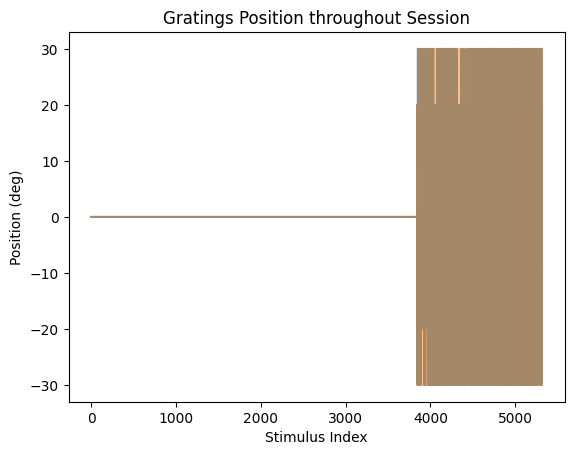

In [11]:
plt.plot(stim_table.x_position, alpha=0.8)
plt.plot(stim_table.y_position, alpha=0.5)
plt.title("Gratings Position throughout Session")
plt.xlabel("Stimulus Index")
plt.ylabel("Position (deg)")

In [12]:
# Receptive Field Mapping starts here, as shown above
first_rf_idx = (stim_table['x_position'] != -0.0).idxmax()
print(f"First RF index: {first_rf_idx}")
stim_table_slice = [first_rf_idx,None]
stim_table = stim_table[slice(*stim_table_slice)]
stim_table

First RF index: 3845


,start_time,stop_time,orientation,trial,delay,diameter,x_position,y_position,contrast,spatial_frequency,temporal_frequency
id,,,,,,,,,,,
3845,2696.360992,2696.610992,1.570796,135.0,0.0,20.0,-20.0,-20.0,0.8,0.08,4.0
3846,2696.628032,2696.878032,1.570796,135.0,0.0,20.0,-20.0,20.0,0.8,0.08,4.0
3847,2696.894976,2697.144976,1.570796,135.0,0.0,20.0,-30.0,-20.0,0.8,0.08,4.0
3848,2697.161984,2697.411984,1.570796,135.0,0.0,20.0,20.0,0.0,0.8,0.08,4.0
3849,2697.428992,2697.678992,1.570796,135.0,0.0,20.0,10.0,-30.0,0.8,0.08,4.0
...,...,...,...,...,...,...,...,...,...,...,...
5310,3087.052000,3087.302000,0.000000,155.0,0.0,20.0,10.0,-10.0,0.8,0.08,4.0
5311,3087.318976,3087.568976,0.785398,155.0,0.0,20.0,10.0,20.0,0.8,0.08,4.0
5312,3087.586016,3087.836016,0.785398,155.0,0.0,20.0,-10.0,-30.0,0.8,0.08,4.0


It can be seen below that the position pairs all occur in the same quanitity. In other sessions, there was a minor bug in which resulted in no receptive field gratings at (-30,-20), and extra gratings at (-30,-30)

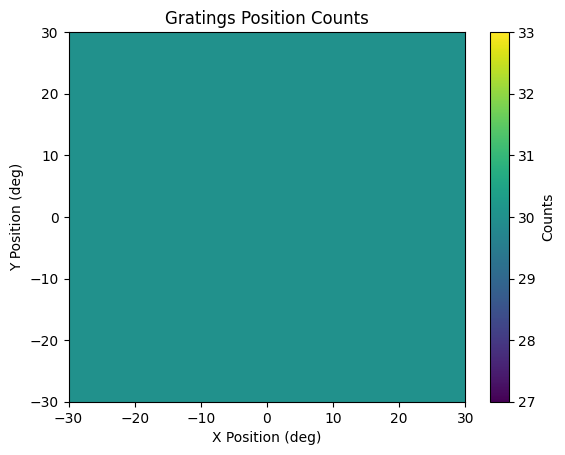

In [13]:
hist, xedges, yedges, im = plt.hist2d(stim_table.x_position,stim_table.y_position, bins=7) 
plt.colorbar(im, label='Counts')
plt.title("Gratings Position Counts")
plt.xlabel("X Position (deg)")
plt.ylabel("Y Position (deg)")
plt.savefig(output_dir / 'positions_hist.png')

### Examining the Ophys
The Optical physiology from slap2 is stored under the 'ophys' section. There are 2 recording planes for slap2, called DMDs. An important note here; at the moment the recorded info is stored under a key called 'DfOverF' but it is actually just Df. It is not normalized for now.

The Df traces are stored in a 2D array with dimensions `time` and `roi` where ROIs are individual dendritic synapses. There is also an associated timestamps array with the timestamps.

In [14]:
dmd1_df = nwb.processing['ophys']['DfOverF']['DMD1_DfOverF']
dmd1_df_data = np.array(dmd1_df.data)
dmd1_df_timestamps = np.array(dmd1_df.timestamps)
print(dmd1_df_data.shape)
print(dmd1_df_timestamps.shape)

(599588, 120)
(599588,)


In [15]:
n_timestamps, n_rois = dmd1_df_data.shape
ts_start, ts_end = dmd1_df_timestamps[0], dmd1_df_timestamps[-1]
std = np.nanstd(dmd1_df_data)
mean = np.nanmean(dmd1_df_data)
std, mean

(np.float64(489.2827109798829), np.float64(277.7846745625279))

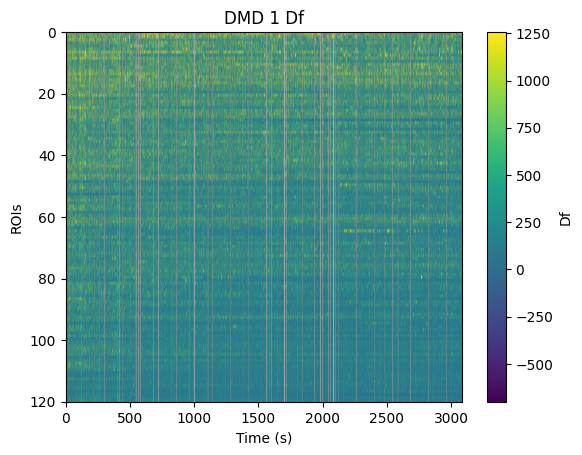

In [16]:
plt.imshow(dmd1_df_data.transpose(), aspect='auto', extent=[ts_start,ts_end,n_rois,0], vmin=mean-2*std, vmax=mean+2*std)
plt.title('DMD 1 Df')
plt.ylabel('ROIs')
plt.xlabel('Time (s)')
plt.colorbar(label='Df')

Here we can see the segmented recording plane for this DMD. Recall that slap2 doesn't not image the entire plane in the field of view, just selected regions to maximize temporal fidelity. These are the individual selected regions. A zoomed-in subregion is also plotted below with the actual recorded activity sites highlighed.

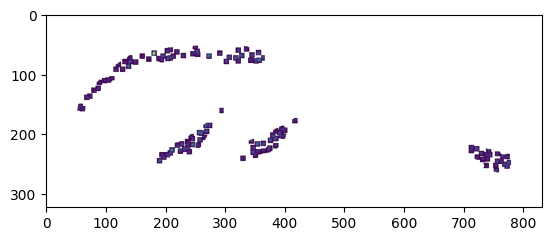

In [17]:
image_masks = nwb.processing['ophys']['ImageSegmentation']['DMD1_plane_segmentation']['image_mask']
image_mask_sum = np.sum(image_masks, axis=0)
plt.imshow(image_mask_sum)


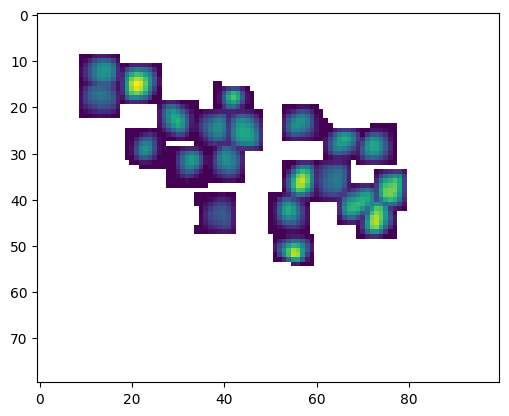

In [18]:
plt.imshow(image_mask_sum[210:290,700:800])

### Receptive Field Analysis
Now the receptive fields will be calculated for each synapse ROI in the recording. Because there are so many, they will be saved as PNGs rather than plotted in the notebook.

In [19]:
def calculate_receptive_fields(stim_table, dff, timestamps, onset_delay, window_duration):
    x_positions = np.unique(stim_table.x_position)
    sorted_x_positions = sorted(x_positions, key=float)
    y_positions = np.unique(stim_table.y_position)
    sorted_y_positions = sorted(y_positions, key=float)

    height, width = len(sorted_y_positions), len(sorted_x_positions)
    n_timestamps, n_rois = dff.shape

    receptive_fields = np.zeros((n_rois, height, width))
    stim_counts = np.zeros((height, width))  # to normalize later

    for i, row in stim_table.iterrows():
        response_start = row['start_time'] + onset_delay
        response_end = row['start_time'] + onset_delay + window_duration

        response_baseline_start = row['start_time'] - 5.5
        response_baseline_end = row['start_time'] - 0.5

        response_baseline_start, response_baseline_end = np.searchsorted(timestamps, (response_baseline_start, response_baseline_end))

        response_start, response_end = np.searchsorted(timestamps, (response_start, response_end))
        
        if response_start >= response_end:
            continue

        response = (np.nanmean(dff[response_start:response_end], axis=0) - np.nanmean(dff[response_baseline_start:response_baseline_end], axis=0)) / np.nanstd(dff[response_baseline_start:response_baseline_end], axis=0)
        # mean response
        response[np.isnan(response)] = 0
        xi = sorted_x_positions.index(row['x_position'])
        yi = sorted_y_positions.index([row['y_position']])
        receptive_fields[:, yi, xi] += response
        stim_counts[yi, xi] += 1

    # Avoid division by zero
    stim_counts[stim_counts == 0] = 1
    receptive_fields = receptive_fields / stim_counts[None, :, :]

    return receptive_fields


In [20]:
def plot_rfs(rfs_matrix, output_dir):
    n_cols = 8
    n_rows = (len(rfs_matrix) // n_cols)
    if len(rfs_matrix) % n_cols != 0:
        n_rows += 1

    fig, axs = plt.subplots(n_rows,n_cols, figsize=(n_cols*3, n_rows*3))
    for i, ax in enumerate(axs.flatten()):
        if i >= len(rfs_matrix):
            ax.axis('off')
            continue
        ax.imshow(rfs_matrix[i], clim=[-0.1, 0.5])
        ax.set_title(f'ROI {i}')
    fig.savefig(output_dir / "all_rfs.png", format="png", dpi=300)
    plt.close(fig)

    fig2 = plt.figure()
    plt.imshow(np.mean(rfs_matrix, axis=0), clim=[-0.1, 0.5])
    plt.savefig(output_dir / "avg_rf.png", format="png", dpi=300)
    plt.close(fig2)


In [21]:
def plot_rf_traces_max_only(stim_table, dff, timestamps, onset_delay, window_duration, output_dir, rfs_matrix):
    x_positions = np.unique(stim_table.x_position)
    sorted_x_positions = sorted(x_positions, key=float)
    y_positions = np.unique(stim_table.y_position)
    sorted_y_positions = sorted(y_positions, key=float)

    full_window_duration = 1.0 + window_duration
    trace_window = np.linspace(-1.0, window_duration, int(np.round(full_window_duration / np.median(np.diff(timestamps)))))
    n_rois = dff.shape[1]

    location_traces = {}
    orientation_by_trial = {}
    stop_offsets = []

    for i, row in stim_table.iterrows():
        x, y = row['x_position'], row['y_position']
        xi = sorted_x_positions.index(x)
        yi = sorted_y_positions.index(y)

        orientation_rad = row.orientation
        orientation_deg = int(round(np.degrees(orientation_rad))) % 180  # Normalize to [0, 180)
        
        start_time = row['start_time']
        stop_time = row['stop_time']

        base_start = start_time - 1.0
        base_end = start_time
        stim_start = start_time + onset_delay
        stim_end = stim_start + window_duration

        base_idx_start, base_idx_end = np.searchsorted(timestamps, (base_start, base_end))
        stim_idx_start, stim_idx_end = np.searchsorted(timestamps, (stim_start, stim_end))

        if stim_idx_end > stim_idx_start and base_idx_end > base_idx_start:
            baseline = dff[base_idx_start:base_idx_end]
            trace = dff[stim_idx_start:stim_idx_end]

            mean_base = np.nanmean(baseline, axis=0)
            std_base = np.nanstd(baseline, axis=0)
            z_baseline = (baseline - mean_base) / (std_base + 1e-10)
            z_trace = (trace - mean_base) / (std_base + 1e-10)

            if z_baseline.shape[0] + z_trace.shape[0] == len(trace_window):
                z_full = np.concatenate((z_baseline, z_trace), axis=0)
                location_traces.setdefault((xi, yi), []).append((z_full, orientation_deg))

                stop_offset = stop_time - stim_start
                stop_offsets.append(stop_offset)

    avg_stop_offset = np.mean(stop_offsets) if stop_offsets else window_duration

    # Assign colors per orientation
    all_orientations = sorted(set(o for traces in location_traces.values() for _, o in traces))
    color_map = plt.cm.get_cmap('tab10', len(all_orientations))
    orientation_colors = {ori: color_map(i) for i, ori in enumerate(all_orientations)}

    for roi in range(n_rois):
        best_response = -np.inf
        best_loc = None

        for (xi, yi), trials in location_traces.items():
            traces = np.stack([t[0] for t in trials])
            mean_resp = np.nanmean(traces[:, :, roi])
            if mean_resp > best_response:
                best_response = mean_resp
                best_loc = (xi, yi)

        if best_loc is None:
            continue

        trials = location_traces[best_loc]
        trace_plot_dir = output_dir / "traces_max" / f"roi_{roi}"
        trace_plot_dir.mkdir(parents=True, exist_ok=True)

        plt.figure(figsize=(8, 4))
        for z_full, orientation_deg in trials:
            color = orientation_colors[orientation_deg]
            plt.plot(trace_window, z_full[:, roi], color=color, alpha=0.4)

        plt.plot(trace_window, np.nanmean([z[:, roi] for z, _ in trials], axis=0), color='black', linewidth=2, label='Mean')
        plt.axvline(0, color='black', linestyle='--', linewidth=1)
        plt.axvline(avg_stop_offset, color='black', linestyle='--', linewidth=1)
        plt.title(f'ROI {roi} - strongest response at x={sorted_x_positions[best_loc[0]]}, y={sorted_y_positions[best_loc[1]]}')
        plt.xlabel('Time (s)')
        plt.ylabel('z-scored dF/F')

        # Add orientation legend
        handles = [plt.Line2D([0], [0], color=color, lw=2, label=f'{ori}°') for ori, color in orientation_colors.items()]
        plt.legend(handles=handles, title="Orientation", loc='upper right')

        plt.tight_layout()
        plt.savefig(trace_plot_dir / f"roi_{roi}_traces.png", dpi=150)
        plt.close()

        # RF map
        plt.figure()
        plt.imshow(rfs_matrix[roi], clim=[-0.1, 0.5])
        plt.title(f"RF map - ROI {roi}")
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(trace_plot_dir / f"roi_{roi}_rf.png", dpi=150)
        plt.close()

### Running Receptive Field Analysis
Set the RF analysis params below here. The `onset_delay` is the time in seconds after which we expect a response to occur, and `window_duration` is the time length of the window in seconds. The plots should result in `output_dir` which was specified at the top of the notebook.

In [22]:
onset_delay = 0.0
window_duration = 0.5

In [23]:
for dmd in [1, 2]:
    dff = np.array(nwb.processing['ophys']['DfOverF'].roi_response_series[f"DMD{dmd}_DfOverF"].data)
    timestamps = np.array(nwb.processing['ophys']['DfOverF'].roi_response_series[f"DMD{dmd}_DfOverF"].timestamps)

    print(f"Getting RFs for dmd {dmd}")
    rfs_matrix = calculate_receptive_fields(stim_table, dff, timestamps, onset_delay, window_duration)

    output_rfs_dir = output_dir / f"delay_{str(onset_delay).replace('.','_')}" / f"duration_{str(window_duration).replace('.','_')}" / f"dmd_{str(dmd)}"
    output_rfs_dir.mkdir(parents=True, exist_ok=True)

    plot_rfs(rfs_matrix, output_rfs_dir)
    plot_rf_traces_max_only(stim_table, dff, timestamps, onset_delay, window_duration, output_rfs_dir, rfs_matrix)

Getting RFs for dmd 1


C:\Users\carter.peene\AppData\Local\Temp\ipykernel_9532\82937762.py:27: RuntimeWarning: Mean of empty slice
  response = (np.nanmean(dff[response_start:response_end], axis=0) - np.nanmean(dff[response_baseline_start:response_baseline_end], axis=0)) / np.nanstd(dff[response_baseline_start:response_baseline_end], axis=0)
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_9532\4216684034.py:38: RuntimeWarning: Mean of empty slice
  mean_base = np.nanmean(baseline, axis=0)
c:\Users\carter.peene\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\carter.peene\AppData\Local\Temp\ipykernel_9532\4216684034.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

Getting RFs for dmd 2
